In [52]:
import numpy as np
from scipy import ndimage
import skimage as ski
from skimage import filters
from skimage.filters import gaussian
from scipy.ndimage import uniform_filter
from scipy import ndimage, signal
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

(384, 288)


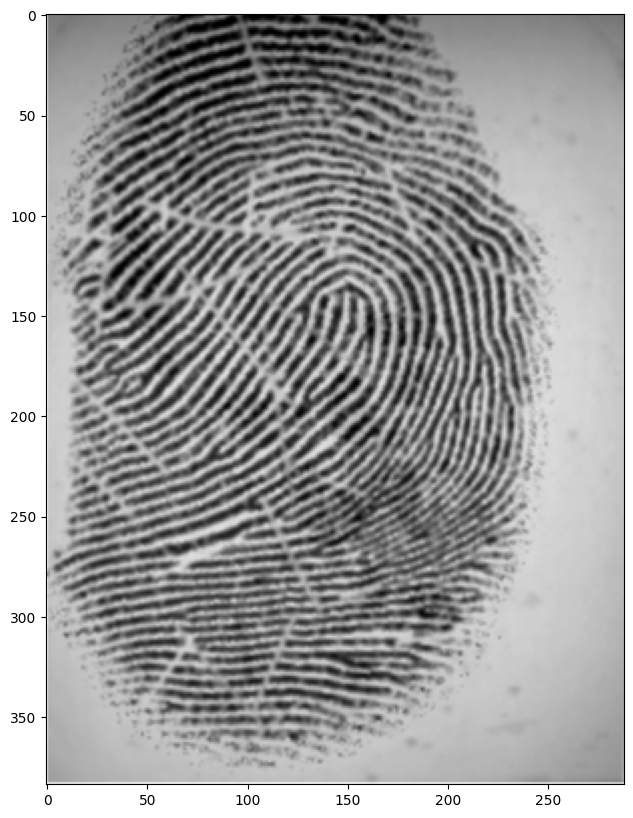

In [53]:
#Read Input Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

# 'data/raw/DB4_B/102_5.tif is SPECIAL!
test_img = cv2.imread('data/raw/DB4_B/102_6.tif', cv2.IMREAD_GRAYSCALE)
print(test_img.shape)

fig = plt.figure(figsize=(20,10))
plt.imshow(test_img, cmap='gray')
plt.show()


Input image: Mean = 127.54279694733796
Input image: Variance = 2154.317341598382


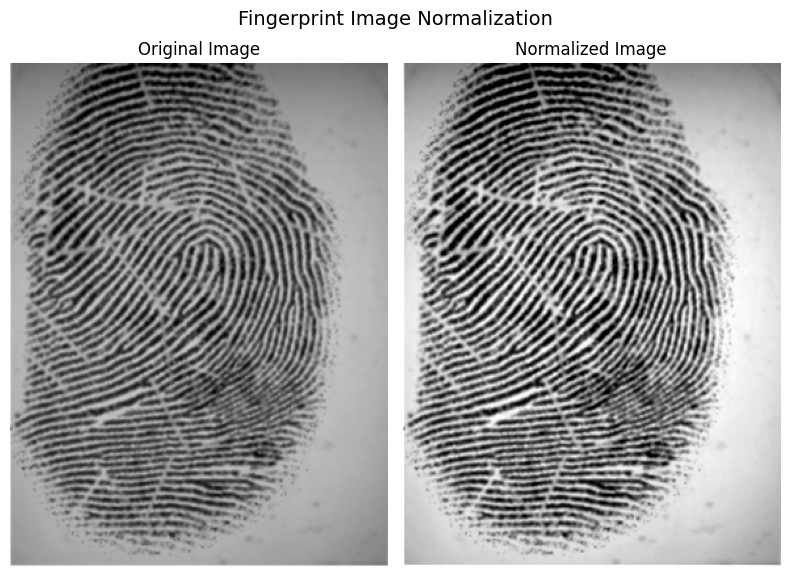

In [54]:
# 1. NORMALIZATION

def normalize_image(img, m0, v0):

    """
    Normalize a grayscale fingerprint image to the given mean and variance

    """
    normalized_img = np.zeros(img.shape)

    m = np.mean(img.flatten())
    v = np.var(img.flatten())
    print(f"Input image: Mean = {m}")
    print(f"Input image: Variance = {v}")


    for y_px in range(img.shape[0]):
        for x_px in range(img.shape[1]):
            
            if img[y_px, x_px] > m:
                normalized_img[y_px, x_px] = m0 + np.sqrt(v0*((img[y_px, x_px]-m)**2)/v)
            else:
                normalized_img[y_px, x_px] = m0 - np.sqrt(v0*((img[y_px, x_px]-m)**2)/v)


    return normalized_img

#Desired Mean and Var = 140, 4000
normalized_img = normalize_image(test_img,150, v0=5000)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(8, 6))

axs[0].imshow(test_img, cmap='gray', vmin=0, vmax=255)
axs[0].set_title("Original Image")
axs[0].axis('off')

axs[1].imshow(normalized_img, cmap='gray', vmin=0, vmax=255)
axs[1].set_title("Normalized Image")
axs[1].axis('off')

plt.suptitle("Fingerprint Image Normalization", fontsize=14)
plt.tight_layout()
plt.show()

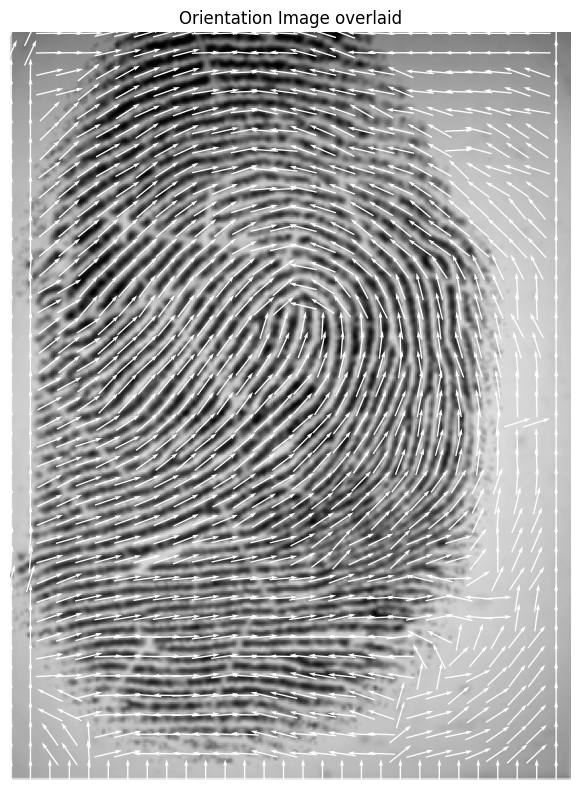

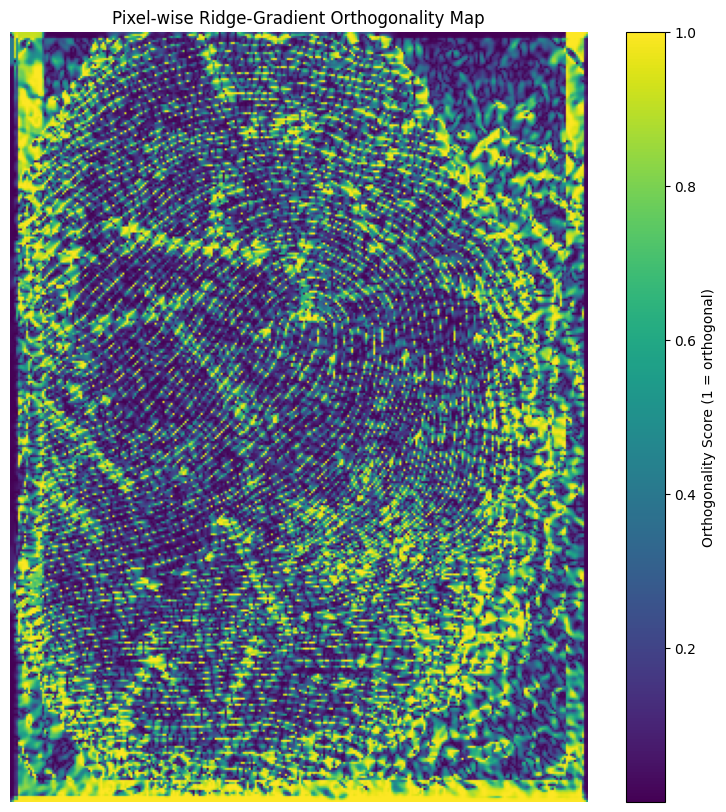

In [55]:
# 2. Orientation Image
# Reference for the gradient calculation only: https://github.com/Utkarsh-Deshmukh
gradient_sigma = 1
sze = int(np.fix(6 * gradient_sigma))
gauss = cv2.getGaussianKernel(sze, gradient_sigma)
gauss2d = gauss @ gauss.T
grad_y_filter, grad_x_filter = np.gradient(gauss2d)

grad_x = signal.convolve2d(test_img, grad_x_filter, mode='same')
grad_y = signal.convolve2d(test_img, grad_y_filter, mode='same')

Vx = np.zeros(test_img.shape)
Vy = np.zeros(test_img.shape)
theta = np.zeros(test_img.shape)
phix = np.zeros(test_img.shape)
phiy = np.zeros(test_img.shape)
w,h = 16, 16


eps=1e-15
for y_px in range(int(h/2), test_img.shape[0]-int(h/2),h):
    for x_px in range(int(w/2), test_img.shape[1]-int(w/2),w):
        
        sum_dx = 0
        sum_dy = 0
        for sub_pxy in range(y_px-int(h/2),y_px+int(h/2)):
            for sub_pxx in range(x_px-int(w/2),x_px+int(w/2)):
                sum_dx += 2*grad_x[sub_pxy,sub_pxx]*grad_y[sub_pxy,sub_pxx]
                sum_dy += ((grad_x[sub_pxy,sub_pxx])**2)-((grad_y[sub_pxy,sub_pxx])**2) 
        
        Vx[y_px, x_px] = sum_dx
        Vy[y_px, x_px] = sum_dy + eps
        theta[y_px, x_px] = 0.5 * np.arctan2(Vx[y_px, x_px],Vy[y_px, x_px]) #Check Vy/Vx or vice versa
        phix[y_px, x_px] = np.cos(2*theta[y_px, x_px])
        phiy[y_px, x_px] = np.sin(2*theta[y_px, x_px])

phix_prime = ski.filters.gaussian(phix, sigma=3)
phiy_prime = ski.filters.gaussian(phiy, sigma=3)

# Orientation Image
orientation_img = 0.5 * np.arctan2(phiy_prime,phix_prime) #Again check ratio order

#Overlay
plt.figure(figsize=(8,8))
plt.imshow(test_img, cmap='gray')

# Prepare grid
X, Y = np.meshgrid(np.arange(test_img.shape[1]), np.arange(test_img.shape[0]))

# Overlay quiver on top of the image
step=10
plt.quiver(
    X[::step, ::step], Y[::step, ::step],
    np.sin(orientation_img)[::step, ::step],
    np.cos(orientation_img)[::step, ::step],
    color='white', pivot='middle', scale=20, headwidth=3, headlength=5
)

plt.title("Orientation Image overlaid")
plt.axis('off')
plt.tight_layout()
plt.show()

#Grad VS Ridge Orthogonality
grad_dir = np.arctan2(grad_y,grad_x)
angle_diff = orientation_img - grad_dir
orthogonality_score = np.abs(np.cos(angle_diff - np.pi / 2))
plt.figure(figsize=(10,10))
plt.imshow(orthogonality_score, cmap='viridis')
plt.colorbar(label='Orthogonality Score (1 = orthogonal)')
plt.title("Pixel-wise Ridge-Gradient Orthogonality Map")
plt.axis('off')
plt.show()

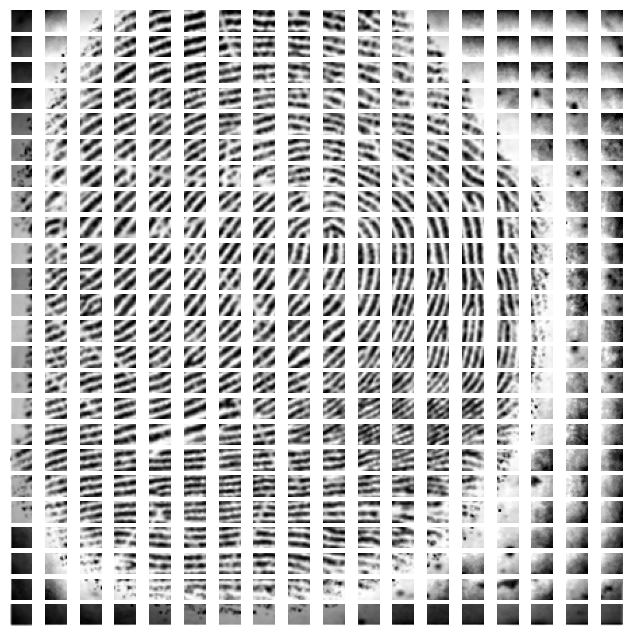

In [56]:
# Visualise 16 x 16 blocks
#Visualise the blocks
h, w = 16, 16  
H, W = test_img.shape

n_rows = H // h
n_cols = W // w

fig, ax = plt.subplots(n_rows, n_cols, figsize=(8,8)) 

axes = ax.flatten() if isinstance(ax, np.ndarray) else [ax]

for i in range(n_rows):
    for j in range(n_cols):
        block = test_img[i*h:(i+1)*h, j*w:(j+1)*w]
        idx = i * n_cols + j
        axes[idx].imshow(block, cmap='gray')
        axes[idx].axis('off') 

plt.show()

/tmp/ipykernel_308014/2678519912.py:23: RuntimeWarning: overflow encountered in scalar add
  G += test_img[int(np.floor(v)),int(np.floor(u))]


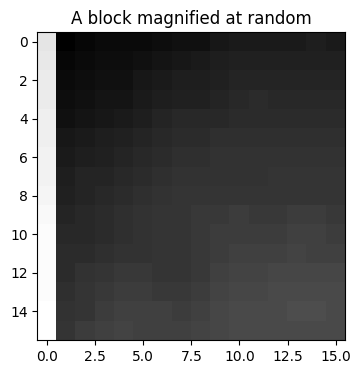

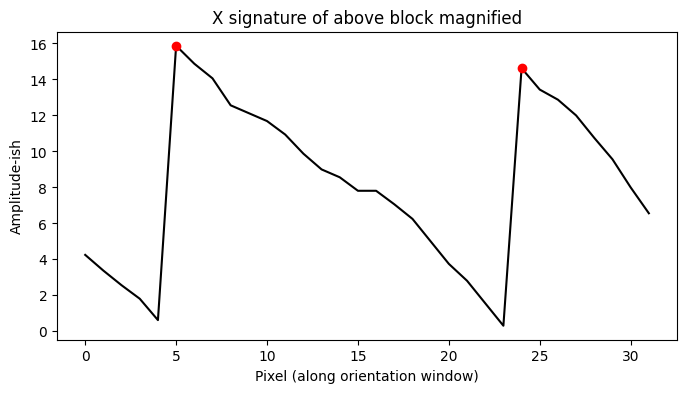

/home/aditya/Aditya_Home/Columbia/DIP/Project/python-fingerprint-enhance/.venv/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/aditya/Aditya_Home/Columbia/DIP/Project/python-fingerprint-enhance/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


(384, 288)


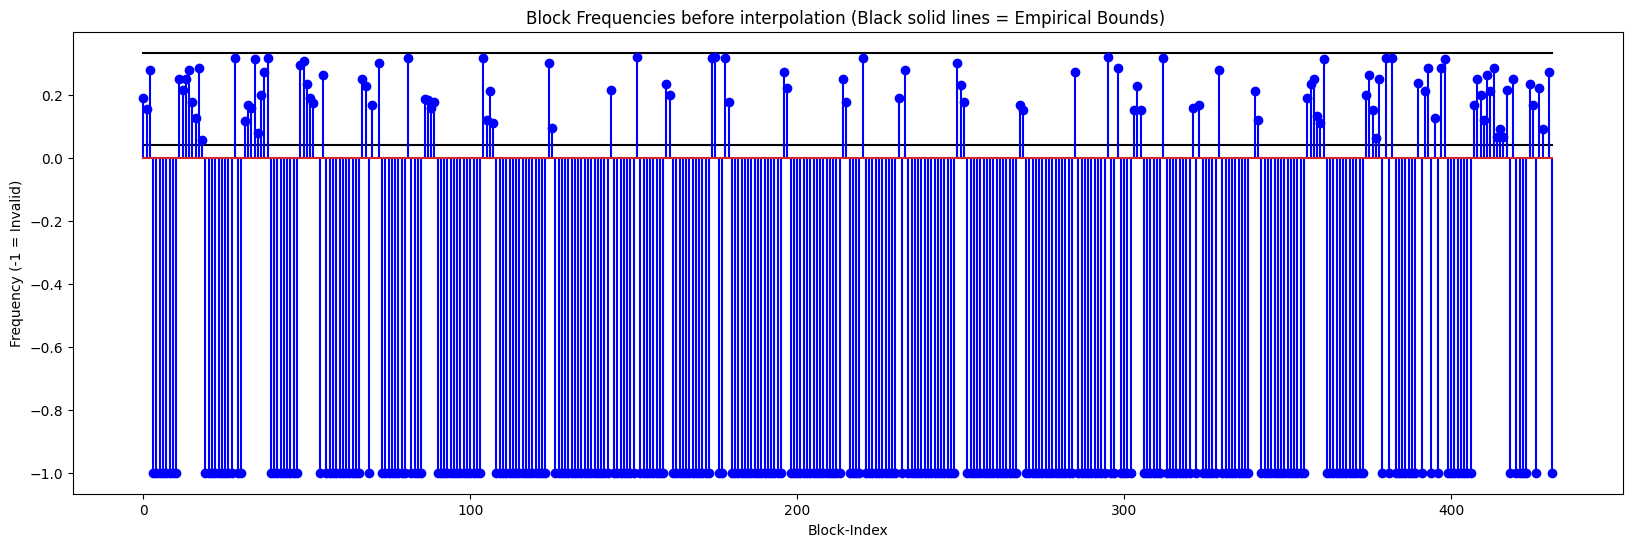

In [57]:
# 3a. Frequency Image Estimation 
# Pick a random block and visualise its X-signature, X-signature of all blocks before interpolation

y_rand = 2
x_rand = 19
eps=1e-15
freq_list = []
omega = np.zeros(test_img.shape)
x_ct, y_ct = 0, 0
for y_px in range(int(h/2), test_img.shape[0],h):
    y_ct += 1
    for x_px in range(int(w/2), test_img.shape[1],w):
        x_ct += 1
        
        l,w  = 32,16
        X = np.zeros(l)
        for k in range(l):
            G = 0
            for d in range(w):
                u = x_px + (d-int(w/2))*np.cos(orientation_img[y_px,x_px]) + (k-int(l/2))*np.sin(orientation_img[y_px,x_px])
                v = y_px + (d-int(w/2))*np.sin(orientation_img[y_px,x_px]) + (int(l/2)-k)*np.cos(orientation_img[y_px,x_px])
                if int(np.floor(v)) < test_img.shape[0] and int(np.floor(u)) < test_img.shape[1]:
                    G += test_img[int(np.floor(v)),int(np.floor(u))]
            X[k] = (1/w)*G
        peaks, _ = find_peaks(X)
        if peaks.shape[0]>0:
            peaks_diff = peaks[1:]-peaks[:-1]
            block_freq = 1/(np.mean(peaks_diff-1)).item()
            if block_freq < 0.04 or block_freq > 0.333:
                block_freq = -1
        else:
            block_freq = -1
        freq_list.append(block_freq)
        omega[y_px, x_px] = block_freq

        if y_ct == y_rand and x_ct == x_rand:
            fig_interm = plt.figure(figsize=(4,4))
            plt.title('A block magnified at random')
            plt.imshow(test_img[y_px-h//2:y_px+h//2,x_px-w//2:x_px+w//2],cmap='gray')
            fig_interm2 = plt.figure(figsize=(8, 4))
            plt.plot(X,'k')
            plt.plot(peaks, X[peaks], "or")
            plt.xlabel('Pixel (along orientation window)')
            plt.ylabel('Amplitude-ish')
            plt.title('X signature of above block magnified')
            plt.show()

print(omega.shape)       
fig_3 = plt.figure(figsize=(20,6))
plt.plot([0.333]*len(freq_list),'-k',label='Upper Bound')
plt.plot([0.04]*len(freq_list),'-k',label='Lower Bound')
plt.stem(freq_list,'b')
plt.xlabel('Block-Index')
plt.ylabel('Frequency (-1 = Invalid)')
plt.title('Block Frequencies before interpolation (Black solid lines = Empirical Bounds) ')
plt.show()

            


Max iterations reached without convergence, there's a problem!!
nan nan


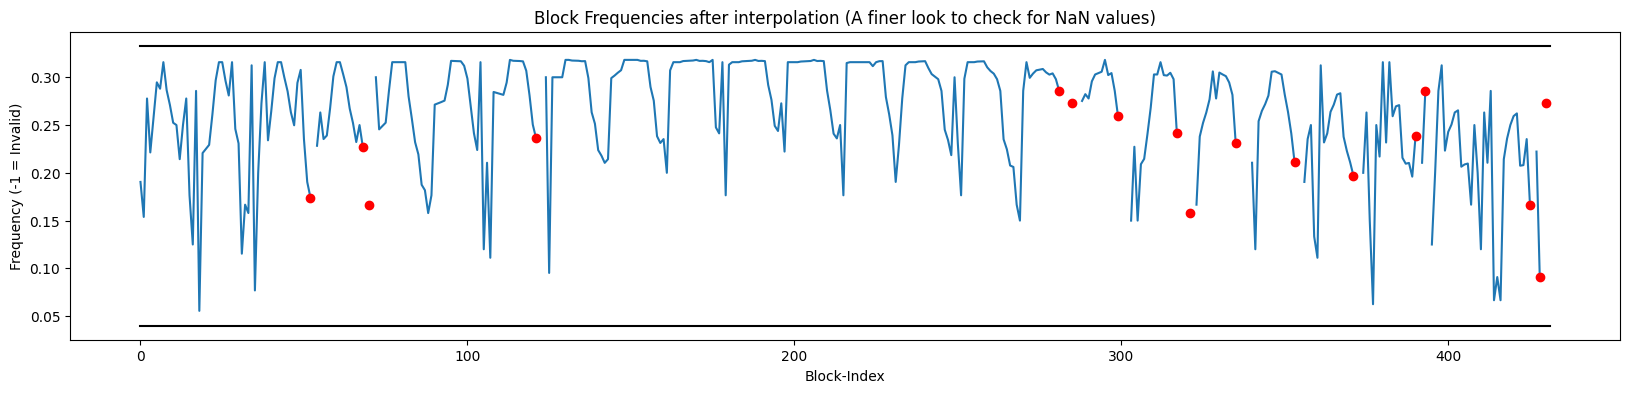

In [58]:
# Interpolation
def mu(x):
    return 0 if x <= 0 else x

def delta(x):
    return 0 if x <= 0 else 1

def generate_gaussian_kernel(size=7, sigma=3):
    ax = np.linspace(-(size // 2), size // 2, size)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))
    return kernel / np.sum(kernel)

max_iter = 15
lower_bound = 0.04
upper_bound = 0.333

omega_prime = omega.copy()

kernel_size = 7
pad = kernel_size // 2
Wg = generate_gaussian_kernel(size=kernel_size, sigma=3)

for iteration in range(max_iter):
    omega_new = omega_prime.copy()
    freq_list_prime = []

    for y_px in range(int(h/2), omega.shape[0], h):
        for x_px in range(int(w/2), omega.shape[1], w):
            num, denom = 0.0, 0.0
            for u in range(-pad, pad + 1):
                for v in range(-pad, pad + 1):
                    yy = y_px - u * h
                    xx = x_px - v * w

                    if 0 <= yy < omega.shape[0] and 0 <= xx < omega.shape[1]:
                        weight = Wg[u + pad, v + pad] 
                        omega_val = omega_prime[int(yy), int(xx)]

                        num += weight * mu(omega_val)
                        denom += weight * delta(omega_val + 1)

            # Sanity Check
            if omega_prime[y_px, x_px] == -1 or not (lower_bound <= omega_prime[y_px, x_px] <= upper_bound) or np.isnan(omega_prime[y_px, x_px]):
                block_freq = num / (denom + 1e-8)
                if block_freq < 0.04 or block_freq > 0.333:
                    block_freq = -1
            else:
                block_freq = omega_prime[y_px, x_px]

            omega_new[y_px, x_px] = block_freq
            freq_list_prime.append(block_freq)

    omega_prime = omega_new

    # Stop if all values are within the valid range
    omega_prime_flat = omega_prime[int(h/2)::h, int(w/2)::w].flatten()
    if np.all((omega_prime_flat >= lower_bound) & (omega_prime_flat <= upper_bound)):
        print(f"Interpolation converged in {iteration + 1} iterations.")
        break
else:
    print(f"Max iterations reached without convergence, there's a problem!!")

omega_prime_flat = omega_prime[int(h/2)::h, int(w/2)::w].flatten()
print(np.min(omega_prime_flat), np.max(omega_prime_flat))
nan_idx = np.where(np.isnan(omega_prime_flat))[0]
prev_idx = nan_idx - 1
fig_sanity = plt.figure(figsize=(20,4))
plt.plot(omega_prime_flat)
plt.plot(prev_idx, omega_prime_flat[prev_idx], 'or')
plt.plot([0.333]*len(freq_list),'k')
plt.xlabel('Block-Index')
plt.ylabel('Frequency (-1 = Invalid)')
plt.title('Block Frequencies after interpolation (A finer look to check for NaN values)')
plt.plot([0.04]*len(freq_list),'k')

fig_5 = plt.figure(figsize=(20,6))
plt.stem(freq_list,'b')
plt.stem(freq_list_prime,'darkorange')
# plt.stem(omega_prime_flat,'*r')
plt.plot([0.333]*len(freq_list),'k')
plt.plot([0.04]*len(freq_list),'k')
plt.xlabel('Block-Index')
plt.ylabel('Frequency (-1 = Invalid)')
plt.title('Block Frequencies after interpolation (Black solid lines = Empirical Bounds) ')
plt.show()

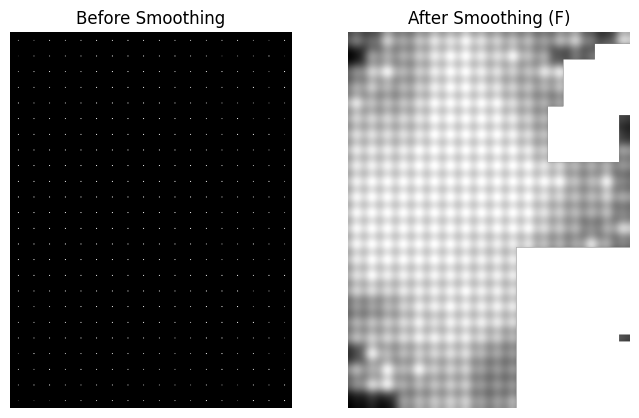

In [64]:
from scipy.ndimage import gaussian_filter
# Visualise Orientation Frequency Image (Before and after Gaussian filtering)
F = gaussian_filter(omega_prime, sigma=7) #Do only after interpolation complete else white masks (i.e. no block has invalid values (outside 0.04,0.333)
fig_4,ax = plt.subplots(1,2,figsize=(8,6))
ax[0].imshow(omega_prime,cmap='gray')
ax[0].set_title('Before Smoothing')
ax[0].axis('off')
ax[1].imshow(F,cmap='gray')
ax[1].set_title('After Smoothing (F)')
ax[1].axis('off')
plt.show()

In [60]:
#4. Gabor Filter based enhancement
E = np.zeros(test_img.shape)

def get_gabor_filter(x, y, phi, f,del_x=0.5, del_y=0.5):

    x_phi = x*np.cos(phi)+y*np.sin(phi)
    y_phi = -x*np.sin(phi)+y*np.cos(phi)
    h = np.exp(-0.5*(((x_phi/del_x)**2)+((y_phi/del_y)**2)))*np.cos(2*np.pi*f*x_phi)
    return h

filter_size = 11
pad = filter_size // 2
for y_px in range(E.shape[0]):
    for x_px in range(E.shape[1]):
        g_sum = 0
        for u in range(-pad, pad + 1):
            for v in range(-pad, pad + 1):
                h = get_gabor_filter(u, v, orientation_img[y_px, x_px], F[y_px, x_px])

                xx = x_px - u
                yy = y_px - v
                if 0 <= yy < test_img.shape[0] and 0 <= xx < test_img.shape[1]:
                    g_sum += h * test_img[yy, xx]



        E[y_px, x_px] = g_sum

fig_5,ax = plt.subplots(1,2,figsize=(8,6))
ax[0].imshow(E,cmap='gray')
ax[0].set_title('Enhanced Image (Final Output: E)')
ax[0].axis('off')
ax[1].imshow(test_img,cmap='gray')
ax[1].set_title('Original Image (Input: I)')
ax[1].axis('off')
plt.tight_layout()
plt.show()